In [ ]:
import math

import matplotlib.pyplot as plt

import mujoco_toolbox as mjtb
from mujoco_toolbox import Wrapper

In [ ]:
mjtb.VERBOSITY = True
mjtb.CAPTURE_PARAMETERS = "all"

In [4]:
xml = """
<mujoco>
        <visual>
        <global offwidth="800" offheight="600" />
    </visual>
    <option><flag gravity="enable" contact="enable" /></option>
    <option timestep="1e-4"/>
    <compiler angle="degree" />

    <default>
        <geom contype="1" conaffinity="1" condim="3" friction=".6 .3 .3" solimp=".999 .999 .001" solref=".001 1" margin="0.001" group="0"/>
    </default>

    <worldbody>
        <light name="top" pos="0 0 3"/>

        <!-- Main body -->
        <body name="body_1" pos="0 0 0.05">
            <joint name="prismatic_1" type="slide" axis="0 0 1" pos="0 0 0"/>
            <geom type="box" size="0.025 0.025 0.025" pos="0 0 0" rgba="1 0 1 1" mass="0.01"/>
            <!--<camera name="camera_1" mode="targetbody" target="box" pos="0 0 -0.5" quat="1 0 0 0" fovy="45"/>-->

            <!-- First leg attached to the main body -->
            <body name="leg_1" pos="0.025 0 -0.025">
                <joint name="joint_1" type="hinge" axis="0 1 0" pos="0 0 0" limited="true" range="0 180"/>
                <geom type="box" size="0.025 0.0125 0.001" pos="0.025 0 0" rgba="0 1 1 1" mass="0.001"/>

                <!-- Second leg attached to the first leg -->
                <body name="leg_2" pos="0.05 0 0">
                    <joint name="joint_2" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="0.1" damping="0.001"/>
                    <geom type="box" size="0.025 0.0125 0.001"  pos="0.025 0 0" rgba="0 0 1 1" mass="0.001"/>
                </body>
            </body>
        </body>

        <!-- Floor plane -->
        <body name="floor" pos="0 0 0">
            <geom pos="0 0 0" size="1 1 0.05" type="plane" rgba="1 1 1 1"/>
        </body>
    </worldbody>

    <contact>
        <exclude body1="body_1" body2="leg_1" />
        <exclude body1="leg_1" body2="leg_2" />
    </contact>

    <actuator>
        <motor name="motor_1" joint="joint_1"/>
    </actuator>

    <sensor>
        <framepos name="body_pos" objtype="body" objname="body_1"/>
    </sensor>
</mujoco>
"""

In [5]:
Vnom = 6
G = 55.5
t_stall = 15 / 100 / G
i_stall = 0.6
R = Vnom / i_stall

kt = t_stall / i_stall
ke = kt

V_control = 5

b_fit = 1.404e-6
kp_fit = 8.896

In [6]:
def legController(model, data):
    # Current state
    w = data.qvel[1]  # Current velocity of joint 1
    actual = data.qpos[1]  # Current position of joint 1

    desired = math.pi if data.time > 1 else 0

    error = desired - actual

    V = kp_fit * error

    V = max(min(V, V_control), -V_control)

    torque = (kt * (V - (ke * w * G)) / R - b_fit * w * G) * G

    data.ctrl[0] = torque  # control first joint
    return

In [7]:
IC = {"qpos": [0, 0, 0]}

model = Wrapper(
    xml=xml, duration=5, fps=30, resolution=(800, 600), init_conditions=IC, controller=legController
).runSim(render=True)

Simulation:   0%|          | 0/50000 [00:00<?, ? step/s]

Function 'runSim' took 8.6662 seconds


In [8]:
model

Wrapper(
  Duration: 5s [fps=30, ts=1e-04]
  Gravity: [ 0.    0.   -9.81],
  Resolution: 800W x 600H
  Bodies (5): world, body_1, leg_1, leg_2, floor
  Joints (3): prismatic_1, joint_1, joint_2
  Actuators (1): motor_1
  Controller: legController
)

In [9]:
len(model.frames)

151

""

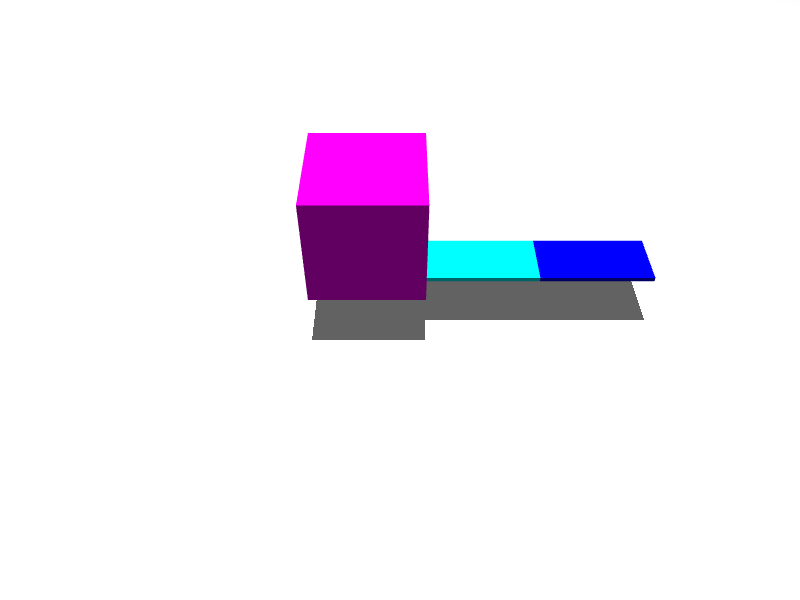

In [10]:
model.renderMedia()

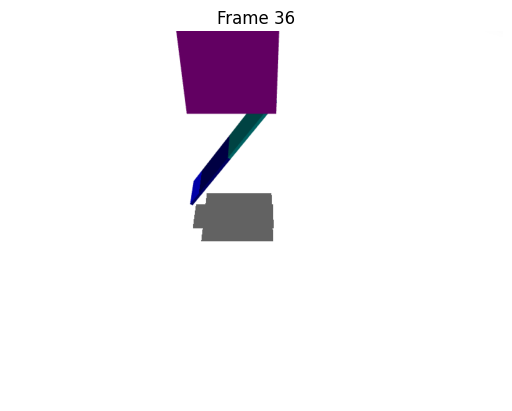

In [11]:
model.renderFrame(t=1.2)

In [12]:
model._captured_data

SimulationData(500 Step(s) Captured)

In [13]:
model._captured_data.shape

time: 500
qpos: 500
qvel: 500
act: 500
qacc: 500
xpos: 500
xquat: 500
xmat: 500
ctrl: 500
sensordata: 500


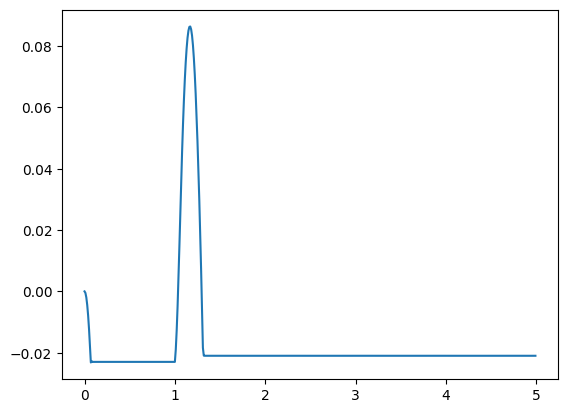

In [14]:
plt.plot(model.captured_data["time"], model.captured_data["qpos"][:, 0])
plt.show()